In [4]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.regularizers import l2
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.applications import ResNet50, VGG16, DenseNet169, MobileNetV2, EfficientNetB0
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model

In [5]:
# Define the paths to the dataset directories
train_dir ="C:/Users/hp/Desktop/fp1/train"
test_dir = "C:/Users/hp/Desktop/fp1/test"

# Define the emotion labels
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [6]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Define hyperparameters
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.001

# List of emotion labels
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Load the dataset function
def load_dataset(directory):
    X = []
    y = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')  # Add more extensions if needed
    for label in emotion_labels:
        label_dir = os.path.join(directory, label)
        if not os.path.isdir(label_dir):
            continue  # Skip non-existing label directories
        for filename in os.listdir(label_dir):
            if not filename.lower().endswith(valid_extensions):
                continue  # Skip non-image files
            img_path = os.path.join(label_dir, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is None:  # Skip unreadable images
                continue
            image = cv2.resize(image, (48, 48))
            image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            X.append(image_rgb)
            y.append(emotion_labels.index(label))
    X = np.array(X)
    y = np.array(y)
    return X, y

# Load and preprocess the data
X_train, y_train = load_dataset(train_dir)
X_test, y_test = load_dataset(test_dir)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert labels to categorical format
y_train = to_categorical(y_train, num_classes=len(emotion_labels))
y_test = to_categorical(y_test, num_classes=len(emotion_labels))

print(f"Training data shape: {X_train.shape}")  # Should be (num_samples, 48, 48, 3)
print(f"Testing data shape: {X_test.shape}")    # Should be (num_samples, 48, 48, 3)


Training data shape: (28709, 48, 48, 3)
Testing data shape: (7229, 48, 48, 3)


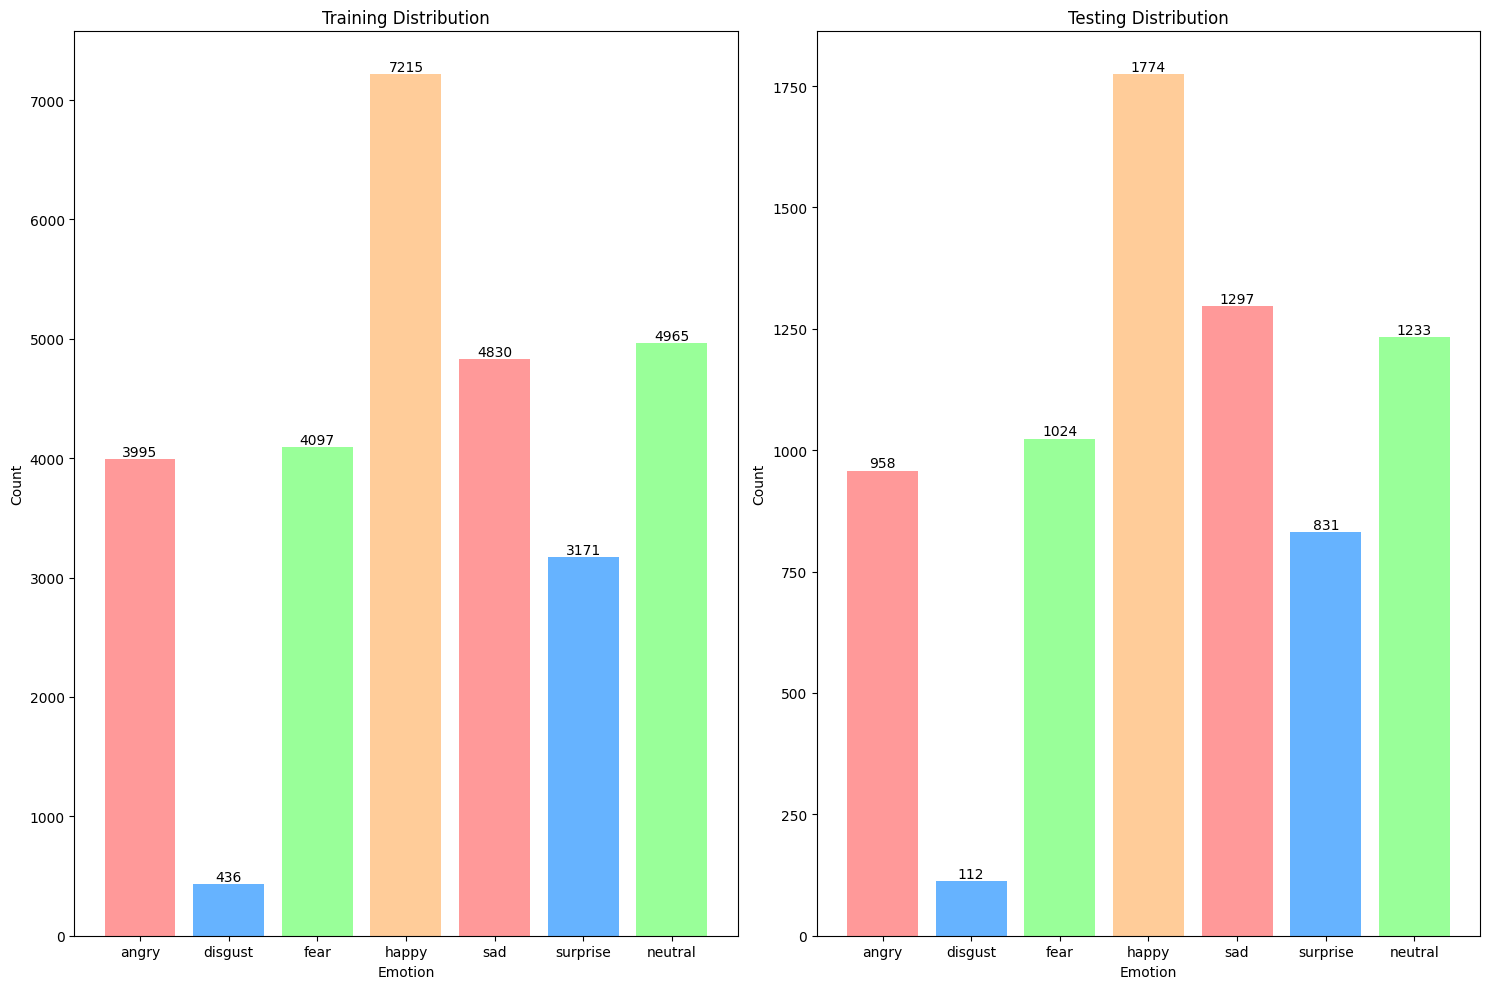

In [7]:
# Function to plot dataset distribution
def plot_dataset_distribution(ax, y, title):
    unique, counts = np.unique(np.argmax(y, axis=1), return_counts=True)    
    # Define colors for each emotion
    colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99']  # Custom color palette
    
    bars = ax.bar(emotion_labels, counts, color=colors)  # Set bar colors
    ax.set_title(title)
    ax.set_xlabel('Emotion')
    ax.set_ylabel('Count')

    # Add value labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 10))  # Create a subplot for training and testing distributions

# Plot training dataset distribution
plot_dataset_distribution(axs[0], y_train, 'Training Distribution')

# Plot testing dataset distribution
plot_dataset_distribution(axs[1], y_test, 'Testing Distribution')

# Adjust layout and save the figure
plt.tight_layout()

plt.savefig("C:/Users/hp/Desktop/fp1/test/emotional")  # Save the figure

#plt.close()  # Close the plot to avoid displaying it immediately

In [8]:
# Enhanced Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
# Learning Rate Scheduler
def create_lr_scheduler():
    return ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6) 

In [10]:
# Function to train the model with improved settings
def train_model(model, X_train, y_train, X_test, y_test, batch_size=BATCH_SIZE, epochs=EPOCHS):
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Increased patience
    lr_scheduler = create_lr_scheduler()  # Add learning rate scheduler

    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        validation_data=(X_test, y_test),
                        steps_per_epoch=len(X_train) // batch_size,
                        epochs=epochs,
                        callbacks=[early_stopping, lr_scheduler])
    
    return history

In [11]:
# Custom CNN Model with L2 Regularization and Batch Normalization
def create_custom_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [12]:
# Fine-tuning function for pre-trained models
def fine_tune_model(model):
    for layer in model.layers:
        layer.trainable = True  # Unfreeze all layers for fine-tuning

In [13]:
# Transfer Learning Models Creation Functions
def create_densenet_model(input_shape, num_classes):
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
        
    return model

In [14]:
def create_resnet_model(input_shape,num_classes):
     base_model = ResNet50(weights='imagenet', include_top=False,input_shape=input_shape)
     x = base_model.output
     x = GlobalAveragePooling2D()(x)
     x = Dense(512 ,activation='relu')(x)
     x = Dropout(0.5)(x)
     predictions=Dense(num_classes ,activation='softmax')(x)

     model=Model(inputs=base_model.input ,outputs=predictions)

     for layer in base_model.layers:
         layer.trainable=False

     return model

In [15]:
def create_vgg_model(input_shape,num_classes):
     base_model=VGG16(weights='imagenet' ,include_top=False,input_shape=input_shape)
     x=base_model.output 
     x=GlobalAveragePooling2D()(x) 
     x=Dense(512 ,activation='relu')(x) 
     x=Dropout(0.5)(x) 
     predictions=Dense(num_classes ,activation='softmax')(x)

     model=Model(inputs=base_model.input ,outputs=predictions)

     for layer in base_model.layers:
         layer.trainable=False

     return model

In [16]:
def create_mobilenet_model(input_shape,num_classes):
     base_model=MobileNetV2(weights='imagenet' ,include_top=False,input_shape=input_shape) 
     x=base_model.output 
     x=GlobalAveragePooling2D()(x) 
     x=Dense(512 ,activation='relu')(x) 
     x=Dropout(0.5)(x) 
     predictions=Dense(num_classes ,activation='softmax')(x)

     model=Model(inputs=base_model.input ,outputs=predictions)

     for layer in base_model.layers:
         layer.trainable=False 

     return model

In [17]:
def create_efficientnet_model(input_shape,num_classes):
      base_model=EfficientNetB0(weights='imagenet' ,include_top=False,input_shape=input_shape) 
      x=base_model.output 
      x=GlobalAveragePooling2D()(x) 
      x=Dense(512 ,activation='relu')(x) 
      x=Dropout(0.5)(x) 
      predictions=Dense(num_classes ,activation='softmax')(x)

      model=Model(inputs=base_model.input ,outputs=predictions)

      for layer in base_model.layers:
          layer.trainable=False 

      return model

In [18]:
# Define input shape and number of classes
input_shape = (48, 48, 3)
num_classes = len(emotion_labels)

In [19]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 6))
    
    # Plotting loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    
    # Save the plot without the extra quote
    plt.savefig(f"C:/Users/hp/Desktop/fp1/test/emotional/{model_name.lower()}_training_history.png")
    plt.show()


Training DenseNet Model...
Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 113s 228ms/step - accuracy: 0.2781 - loss: 1.7904 - val_accuracy: 0.3598 - val_loss: 1.6363 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.3281 - loss: 1.8209 - val_accuracy: 0.3580 - val_loss: 1.6399 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 110s 245ms/step - accuracy: 0.3245 - loss: 1.6851 - val_accuracy: 0.3551 - val_loss: 1.6319 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.3281 - loss: 1.6413 - val_accuracy: 0.3559 - val_loss: 1.6299 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 110s 245ms/step - accuracy: 0.3372 - loss: 1.6682 - val_accuracy: 0.3693 - val_loss: 1.6101 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.2969 - loss: 1.6347 - val_accuracy: 0.3655 - val_loss: 1.6141 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 111

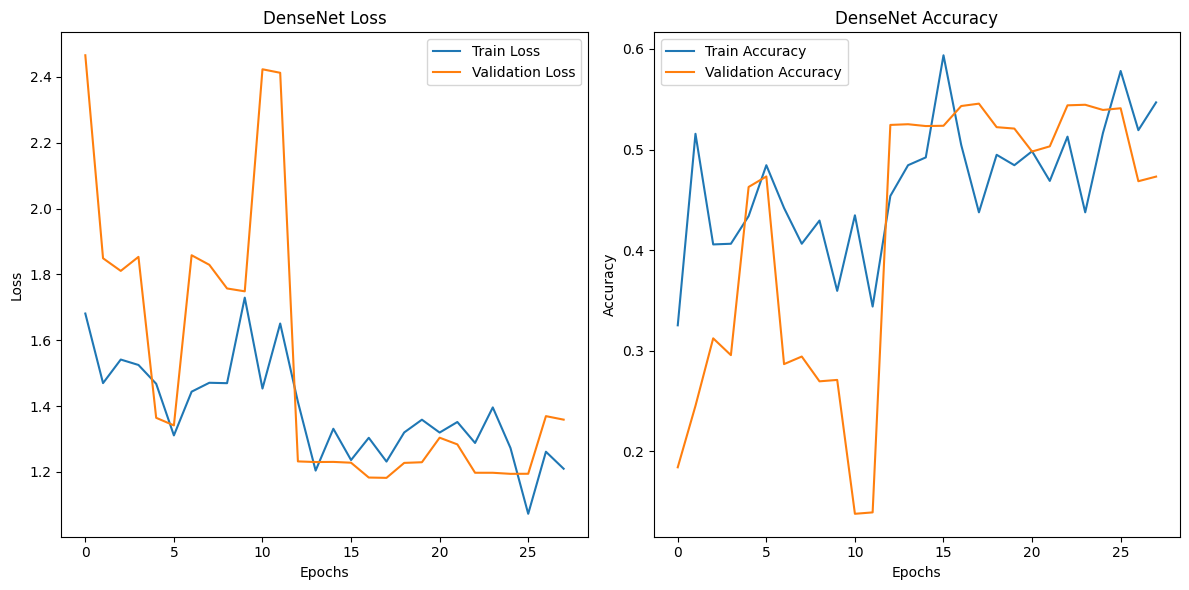

In [28]:
# Create and train DenseNet model
def train_densenet_model():
    densenet_model = create_densenet_model(input_shape, num_classes)
    print("Training DenseNet Model...")
    pretrained_history = train_model(densenet_model, X_train, y_train, X_test, y_test)
    fine_tune_model(densenet_model)
    pretrained_history_fine_tune = train_model(densenet_model, X_train, y_train, X_test, y_test)
    
    # Plot training history for DenseNet
    plot_training_history(pretrained_history_fine_tune, "DenseNet")

     # Save the trained model
    model_save_path = 'C:/Users/hp/Desktop/fp1/test/emotional/densenet_model.keras'  # Specify your desired file path
    densenet_model.save(model_save_path)
    
    return densenet_model, pretrained_history, pretrained_history_fine_tune

densenet_model ,densenet_history ,densenet_history_fine_tune=train_densenet_model()

Training ResNet Model...
Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 130s 281ms/step - accuracy: 0.2246 - loss: 1.8764 - val_accuracy: 0.2471 - val_loss: 1.8122 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.2344 - loss: 1.8079 - val_accuracy: 0.2471 - val_loss: 1.8116 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 132s 295ms/step - accuracy: 0.2503 - loss: 1.8159 - val_accuracy: 0.2471 - val_loss: 1.8114 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.3125 - loss: 1.8344 - val_accuracy: 0.2471 - val_loss: 1.8110 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 129s 288ms/step - accuracy: 0.2514 - loss: 1.8214 - val_accuracy: 0.2471 - val_loss: 1.8121 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.2500 - loss: 1.7974 - val_accuracy: 0.2471 - val_loss: 1.8118 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 131s 

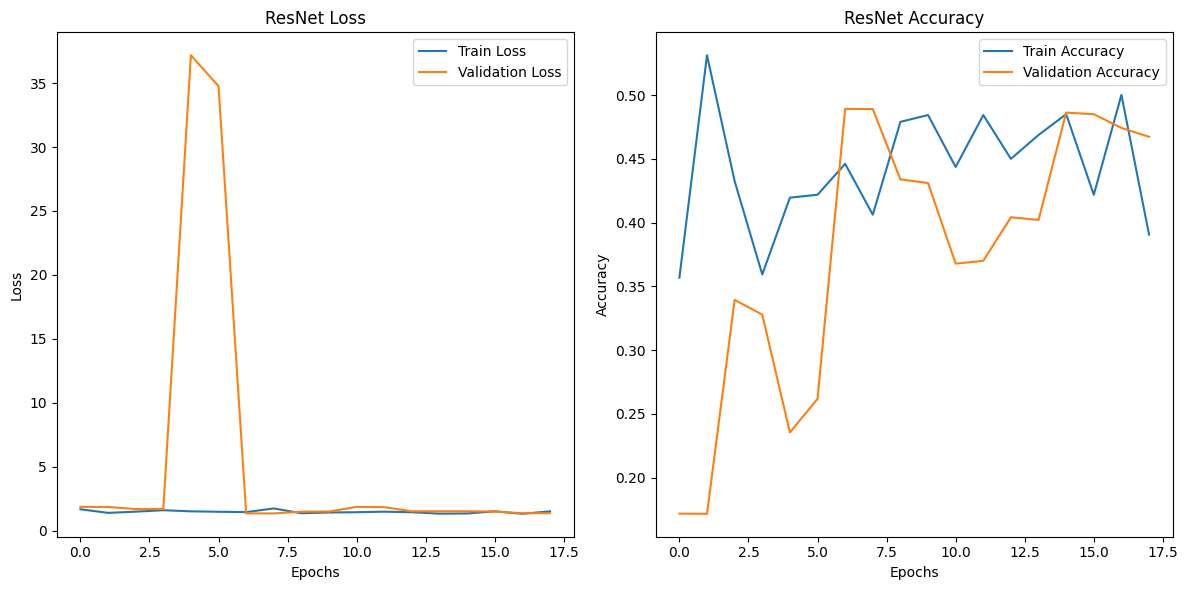

In [29]:
# Create and train ResNet model  
def train_resnet_model():
    resnet_model = create_resnet_model(input_shape, num_classes)
    print("Training ResNet Model...")
    pretrained_history = train_model(resnet_model, X_train, y_train, X_test, y_test)
    fine_tune_model(resnet_model)
    pretrained_history_fine_tune = train_model(resnet_model, X_train, y_train, X_test, y_test)

    # Plot training history for ResNet
    plot_training_history(pretrained_history_fine_tune, "ResNet")

     # Save the trained model
    model_save_path = 'C:/Users/hp/Desktop/fp1/test/emotional/resnet_model.keras'  # Specify your desired file path
    resnet_model.save(model_save_path)

    return resnet_model, pretrained_history, pretrained_history_fine_tune

resnet_model ,resnet_history ,resnet_history_fine_tune=train_resnet_model()

Training VGG Model...
Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 283s 630ms/step - accuracy: 0.2702 - loss: 1.7948 - val_accuracy: 0.3383 - val_loss: 1.6522 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 63s 139ms/step - accuracy: 0.3906 - loss: 1.6220 - val_accuracy: 0.3404 - val_loss: 1.6500 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 287s 641ms/step - accuracy: 0.3181 - loss: 1.6980 - val_accuracy: 0.3506 - val_loss: 1.6280 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 58s 129ms/step - accuracy: 0.3281 - loss: 1.6612 - val_accuracy: 0.3514 - val_loss: 1.6283 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 279s 623ms/step - accuracy: 0.3231 - loss: 1.6857 - val_accuracy: 0.3666 - val_loss: 1.6126 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 53s 119ms/step - accuracy: 0.3594 - loss: 1.6162 - val_accuracy: 0.3690 - val_loss: 1.6114 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 245s 

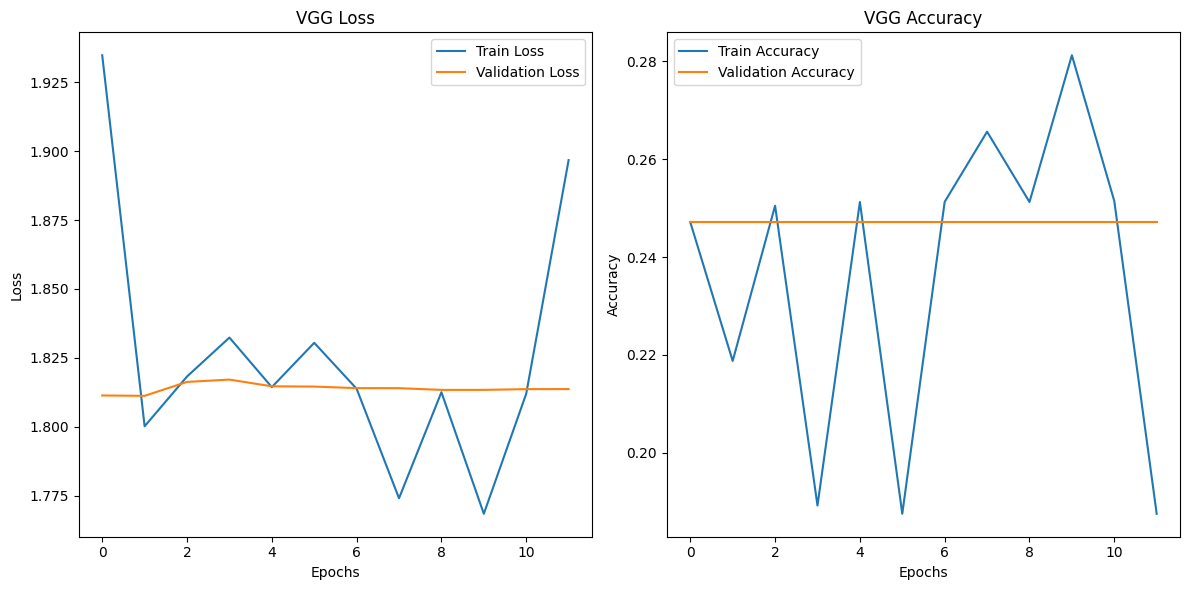

In [31]:
# Create and train VGG model
def train_vgg_model():
    vgg_model = create_vgg_model(input_shape, num_classes)
    print("Training VGG Model...")
    pretrained_history = train_model(vgg_model, X_train, y_train, X_test, y_test)
    fine_tune_model(vgg_model)
    pretrained_history_fine_tune = train_model(vgg_model, X_train, y_train, X_test, y_test)

    # Plot training history for VGG
    plot_training_history(pretrained_history_fine_tune, "VGG")

     # Save the trained model
    model_save_path = 'C:/Users/hp/Desktop/fp1/test/emotional/vgg_model.keras'# Specify your desired file path
    vgg_model.save(model_save_path)

    return vgg_model, pretrained_history, pretrained_history_fine_tune

vgg_model ,vgg_history ,vgg_history_fine_tune=train_vgg_model()

Training MobileNet Model...
Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - accuracy: 0.2617 - loss: 1.9099 - val_accuracy: 0.3370 - val_loss: 1.6623 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.2656 - loss: 1.7507 - val_accuracy: 0.3370 - val_loss: 1.6608 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 76s 170ms/step - accuracy: 0.3051 - loss: 1.7076 - val_accuracy: 0.3392 - val_loss: 1.6666 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.2188 - loss: 1.7193 - val_accuracy: 0.3399 - val_loss: 1.6653 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 76s 169ms/step - accuracy: 0.3059 - loss: 1.7034 - val_accuracy: 0.3307 - val_loss: 1.6450 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.3438 - loss: 1.6971 - val_accuracy: 0.3314 - val_loss: 1.6452 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 75s 1

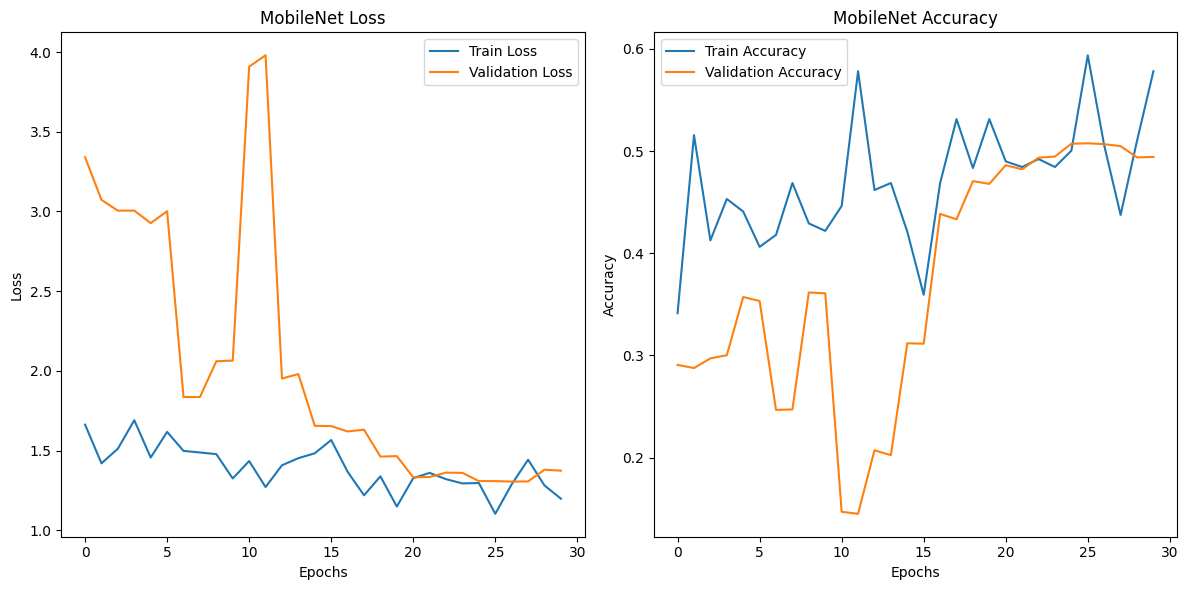

In [32]:
def train_mobilenet_model():
    mobilenet_model = create_mobilenet_model(input_shape, num_classes)
    print("Training MobileNet Model...")
    pretrained_history = train_model(mobilenet_model, X_train, y_train, X_test, y_test)
    fine_tune_model(mobilenet_model)
    pretrained_history_fine_tune = train_model(mobilenet_model, X_train, y_train, X_test, y_test)

    # Plot training history for MobileNet
    plot_training_history(pretrained_history_fine_tune, "MobileNet")

    # Corrected file path
    model_save_path = 'C:/Users/hp/Desktop/fp1/test/emotional/mobilenet_model.keras'

    # Save the trained model
    mobilenet_model.save(model_save_path)

    return mobilenet_model, pretrained_history, pretrained_history_fine_tune

mobilenet_model, mobilenet_history, mobilenet_history_fine_tune = train_mobilenet_model()


Training EfficientNet Model...
Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 84s 163ms/step - accuracy: 0.2274 - loss: 1.8615 - val_accuracy: 0.2471 - val_loss: 1.8144 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.2812 - loss: 1.7968 - val_accuracy: 0.2471 - val_loss: 1.8143 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 74s 164ms/step - accuracy: 0.2502 - loss: 1.8207 - val_accuracy: 0.2471 - val_loss: 1.8141 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.2656 - loss: 1.7827 - val_accuracy: 0.2471 - val_loss: 1.8145 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 73s 164ms/step - accuracy: 0.2525 - loss: 1.8169 - val_accuracy: 0.2471 - val_loss: 1.8148 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.1875 - loss: 1.8280 - val_accuracy: 0.2471 - val_loss: 1.8149 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 75

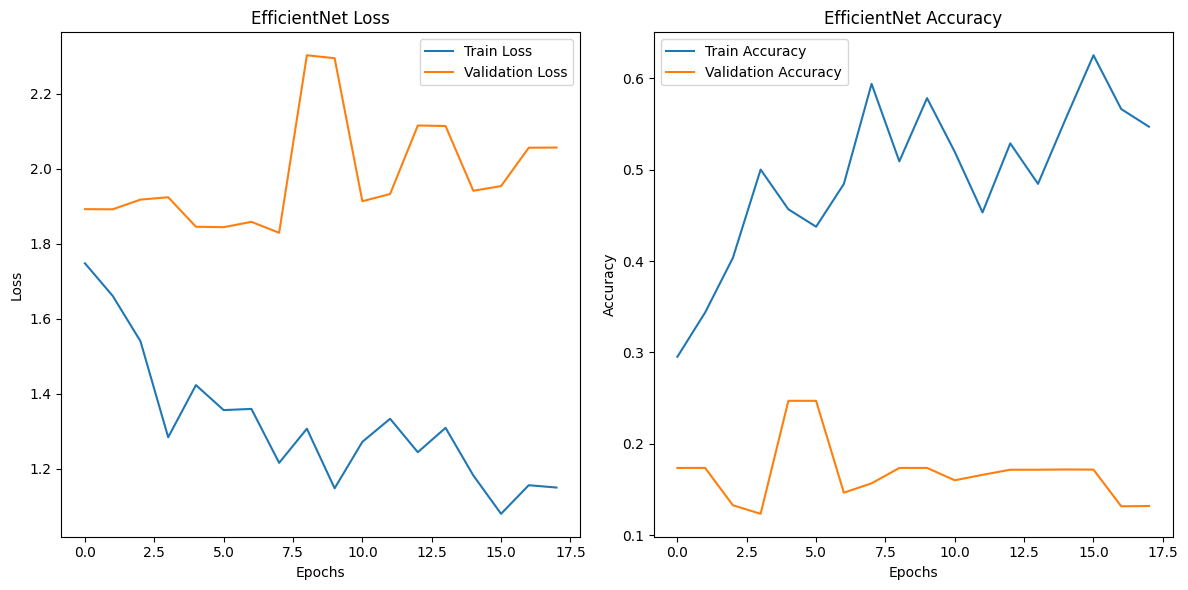

In [33]:
def train_efficientnet_model():
    efficientnet_model = create_efficientnet_model(input_shape, num_classes)
    print("Training EfficientNet Model...")
    pretrained_history = train_model(efficientnet_model, X_train, y_train, X_test, y_test)
    fine_tune_model(efficientnet_model)
    pretrained_history_fine_tune = train_model(efficientnet_model, X_train, y_train, X_test, y_test)

    # Plot training history for EfficientNet
    plot_training_history(pretrained_history_fine_tune, "EfficientNet")

    # Corrected file path
    model_save_path = 'C:/Users/hp/Desktop/fp1/test/emotional/efficientnet_model.keras'

    # Save the trained model
    efficientnet_model.save(model_save_path)

    return efficientnet_model, pretrained_history, pretrained_history_fine_tune

efficientnet_model, efficientnet_history, efficientnet_history_fine_tune = train_efficientnet_model()


Training Custom CNN Model...
Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 50s 106ms/step - accuracy: 0.1873 - loss: 3.1759 - val_accuracy: 0.2461 - val_loss: 2.4250 - learning_rate: 0.0010
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2812 - loss: 2.5031 - val_accuracy: 0.2421 - val_loss: 2.4294 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - accuracy: 0.2366 - loss: 2.4757 - val_accuracy: 0.2915 - val_loss: 2.1915 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1562 - loss: 2.4720 - val_accuracy: 0.2934 - val_loss: 2.1892 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - accuracy: 0.2617 - loss: 2.2548 - val_accuracy: 0.3145 - val_loss: 2.0366 - learning_rate: 0.0010
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2188 - loss: 2.1501 - val_accuracy: 0.3219 - val_loss: 2.0220 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/

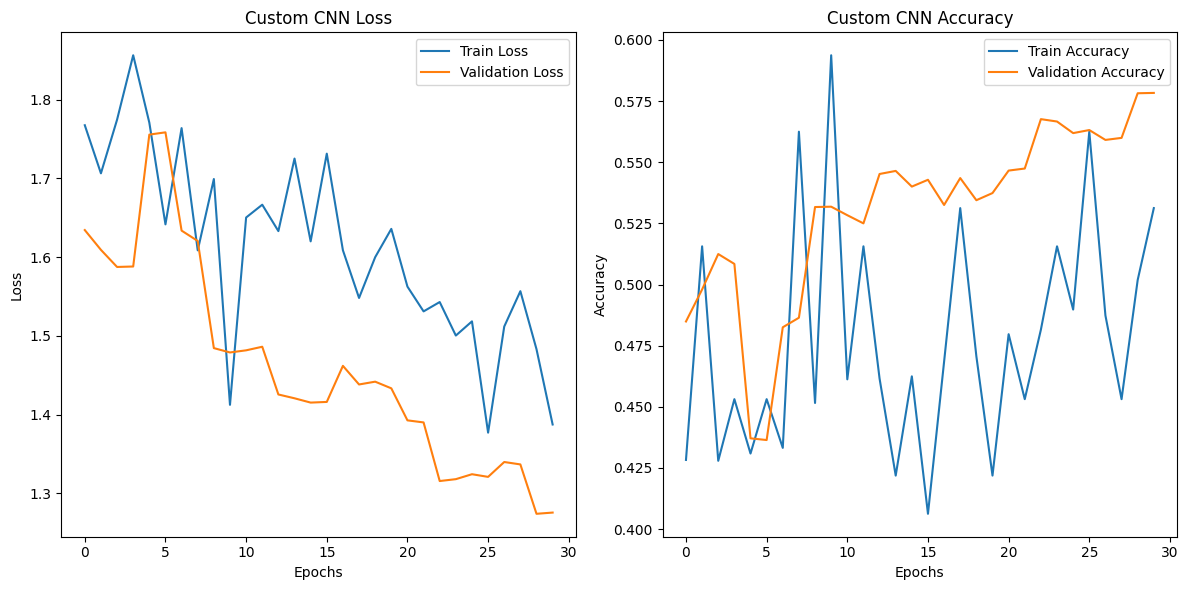

In [34]:
def train_custom_cnn_model():
    custom_cnn_model = create_custom_cnn_model(input_shape, num_classes)
    print("Training Custom CNN Model...")
    
    # Train the model initially
    pretrained_history = train_model(custom_cnn_model, X_train, y_train, X_test, y_test)
    
    # Fine-tune the model
    fine_tune_model(custom_cnn_model)
    
    # Retrain the model after fine-tuning
    pretrained_history_fine_tune = train_model(custom_cnn_model, X_train, y_train, X_test, y_test)

    # Plot training history for Custom CNN
    plot_training_history(pretrained_history_fine_tune, "Custom CNN")

    # Corrected file path
    model_save_path = 'C:/Users/hp/Desktop/fp1/test/emotional/custom_cnn_model.keras'

    # Save the trained model
    custom_cnn_model.save(model_save_path)

    return custom_cnn_model, pretrained_history, pretrained_history_fine_tune

# Train and fine-tune Custom CNN Model
custom_cnn_model, custom_cnn_history, custom_cnn_history_fine_tune = train_custom_cnn_model()


In [1]:
# Function to evaluate performance metrics including ROC AUC score
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)

    # Ensure y_test_classes is correctly formatted
    y_test_classes = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test 

    report = classification_report(y_test_classes, predicted_classes, zero_division=1)
    roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')
    
    return loss, accuracy, report, roc_auc

In [21]:
# List of model file paths
model_paths = [
    r"C:/Users/hp/Desktop/fp1/test/emotional/custom_cnn_model.keras",
    r"C:/Users/hp/Desktop/fp1/test/emotional/densenet_model.keras",
    r"C:/Users/hp/Desktop/fp1/test/emotional/efficientnet_model.keras",
    r"C:/Users/hp/Desktop/fp1/test/emotional/mobilenet_model.keras",
    r"C:/Users/hp/Desktop/fp1/test/emotional/resnet_model.keras",
    r"C:/Users/hp/Desktop/fp1/test/emotional/vgg_model.keras"
]

In [22]:
# Evaluate all models and store results
results = {}

for model_path in model_paths:
    print(f"Loading model from {model_path}...")
    model = load_model(model_path)
    
    print("Evaluating model...")
    loss, accuracy, report, roc_auc = evaluate_model(model, X_test, y_test)
    
    # Store results in a dictionary
    results[model_path] = {
        'loss': loss,
        'accuracy': accuracy,
        'classification_report': report,
        'roc_auc': roc_auc
    }
    
    print(f"Model: {model_path}")
    print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")
    print(report)

Loading model from C:/Users/hp/Desktop/fp1/test/emotional/custom_cnn_model.keras...
Evaluating model...
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4860 - loss: 1.4341
226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Model: C:/Users/hp/Desktop/fp1/test/emotional/custom_cnn_model.keras
Loss: 1.2971, Accuracy: 0.5744, ROC AUC: 0.8705
              precision    recall  f1-score   support

           0       0.51      0.46      0.48       958
           1       0.44      0.11      0.17       112
           2       0.39      0.21      0.27      1024
           3       0.82      0.83      0.82      1774
           4       0.44      0.46      0.45      1297
           5       0.63      0.77      0.69       831
           6       0.48      0.65      0.55      1233

    accuracy                           0.57      7229
   macro avg       0.53      0.49      0.49      7229
weighted avg       0.56      0.57      0.56      7229

Loading model from C:/Users/hp/Desktop/fp1/test/emotional/densen

In [23]:
# Determine best performing model based on accuracy
best_model_path = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_performance = results[best_model_path]

print("\nBest Performing Model:")
print(f"Model Path: {best_model_path}")
print(f"Loss: {best_performance['loss']:.4f}, Accuracy: {best_performance['accuracy']:.4f}, ROC AUC: {best_performance['roc_auc']:.4f}")


Best Performing Model:
Model Path: C:/Users/hp/Desktop/fp1/test/emotional/custom_cnn_model.keras
Loss: 1.2971, Accuracy: 0.5744, ROC AUC: 0.8705
